In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

import string

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print("Trainin Shape:{}".format(train.shape))
print("Training Memory usage:{:.2f}MB".format(train.memory_usage().sum()/1024**2))

print("Test Shape:{}".format(test.shape))
print("Test Memory usage:{:.2f}MB".format(test.memory_usage().sum()/1024**2))


Trainin Shape:(7613, 5)
Training Memory usage:0.29MB
Test Shape:(3263, 4)
Test Memory usage:0.10MB


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

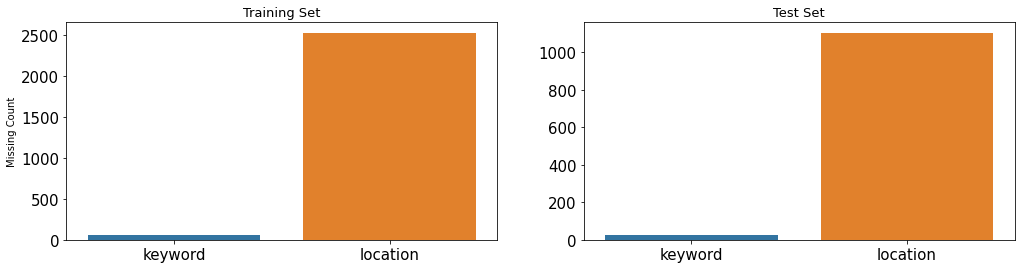

In [8]:
missing_cols = ["keyword","location"]
fig,axes = plt.subplots(ncols=2,figsize=(17,4))

sns.barplot(x=train[missing_cols].isnull().sum().index,y=train[missing_cols].isnull().sum().values,ax=axes[0])
sns.barplot(x=test[missing_cols].isnull().sum().index,y=test[missing_cols].isnull().sum().values,ax=axes[1])

axes[0].set_ylabel("Missing Count")
axes[0].tick_params(axis='x',labelsize=15)
axes[0].tick_params(axis='y',labelsize=15)

axes[1].tick_params(axis='x',labelsize=15)
axes[1].tick_params(axis='y',labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

In [9]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()}(Training) - {test["keyword"].nunique()}(Test)')
print(f'Number of unique values in location = {train["location"].nunique()}(Training) - {test["location"].nunique()}(Test)')

Number of unique values in keyword = 221(Training) - 221(Test)
Number of unique values in location = 3341(Training) - 1602(Test)


In [10]:
#word count
train['word_count'] = train["text"].apply(lambda x :len(str(x).split()))
test['word_count'] = test["text"].apply(lambda x :len(str(x).split()))


#unique word count
train["unique_word_count"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["unique_word_count"] = test["text"].apply(lambda x: len(set(str(x).split())))



In [11]:
# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

In [12]:
#char count
train["char_count"] = train["text"].apply(lambda x:len(str(x)))
test["char_count"] = test["text"].apply(lambda x:len(str(x)))

In [13]:
#string count
train["string_count"] = train["text"].apply(lambda x:len([w for w in str(x) if w in string.punctuation]))
test["string_count"] = test["text"].apply(lambda x:len([w for w in str(x) if w in string.punctuation]))

In [14]:
#hash tag
train["hash_tag"] = train["text"].apply(lambda x:len([w for w in str(x) if w=='#']))
test["hash_tag"] = test["text"].apply(lambda x:len([w for w in str(x) if w=='#']))

#mention count
train["mention_count"] = train["text"].apply(lambda x:len([w for w in str(x) if w=='@']))
test["mention_count"] = test["text"].apply(lambda x:len([w for w in str(x) if w=='@']))

In [15]:
sentences = train.text.values
labels = train.target.values
sentences_test = test.text.values

In [16]:
sentences

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [17]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn.functional as F

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [19]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [20]:
max_len = 0

# Decide on a constant maximum sentence length for padding / truncating to 
# by choosing the max length of the sentences in the dataset.
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [21]:
input_ids = []
attention_masks = []


for i in sentences:
    encoded_dict = tokenizer.encode_plus(
    sent,
        add_special_tokens=True,
        max_length=64,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\user\Anaconda3\envs\nlp_new\lib\site-packages\transformers\tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [22]:
input_ids.append(encoded_dict['input_ids'])
attention_masks.append(encoded_dict['attention_mask'])


In [23]:
attention_masks

[tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])]

In [24]:
# Print sentence 0, now as a list of IDs.
print('Original sentence: ', sentences[0])
print('Token IDs list:', input_ids[0])

Original sentence:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs list: tensor([[  101,  1996,  6745,  1024,  2062,  5014, 10958,  5422,  2011,  2642,
          2662,  3748, 10273,  1011,  5925,  2739,  8299,  1024,  1013,  1013,
          1056,  1012,  2522,  1013,  1061,  8029,  2549, 27472,  4160, 29097,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])


In [25]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [37]:
attention_masks.shape

torch.Size([1, 64])

In [36]:
input_ids.shape

torch.Size([1, 64])

In [43]:
dataset = [input_ids,attention_masks,labels]

In [45]:
labels.shape

torch.Size([7613])

In [46]:
tokenizer.tokenize("Hello,how are you!!")

['hello', ',', 'how', 'are', 'you', '!', '!']

In [48]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Hello,how are you!!"))

[7592, 1010, 2129, 2024, 2017, 999, 999]

In [49]:
import tensorflow_hub as hub
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow_hub'